In [5]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import time
import numpy as np
import pandas as pd

# BESOS
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP, EvaluatorGeneric
from besos.parameters import (
    Parameter,
    RangeParameter,
    FieldSelector,
    expand_plist,
    wwr,
    CategoryParameter,
    GenericSelector
)
from besos.problem import EPProblem, Problem
from besos.optimizer import NSGAII

# Visualización
import matplotlib.pyplot as plt
from seaborn import heatmap, pairplot
from plotly import express as px

# Scikit-learn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import warnings

from epw import epw

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [6]:
building = ef.get_building("Office_IDF.idf")
epw_file='Larnaca_Larnax_Airp_-hour.epw'

In [7]:
meteo = epw()
meteo.read(epw_file)
meteo.dataframe.describe()

,Year,Month,Day,Hour,Minute,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,Extraterrestrial Horizontal Radiation,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
count,8760.0,8760.000000,8760.000000,8760.000000,8760.0,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.0,8760.0,8760.0,8760.000000,8760.000000,8760.0,8760.000000,8.760000e+03,8760.000000,8760.0
mean,2005.0,6.526027,15.720548,12.500000,60.0,20.339623,13.321301,66.312557,101277.640982,348.568493,...,99999.0,9.0,999999999.0,25.495662,0.174258,0.0,74.213014,2.000000e-01,0.037705,99.0
std,0.0,3.448048,8.796749,6.922582,0.0,7.095390,5.653212,16.089700,188.766190,434.018625,...,0.0,0.0,0.0,10.274516,0.060578,0.0,26.073199,2.775716e-17,0.375435,0.0
min,2005.0,1.000000,1.000000,1.000000,60.0,2.600000,-1.600000,30.000000,100507.000000,0.000000,...,99999.0,9.0,999999999.0,8.000000,0.039000,0.0,0.000000,2.000000e-01,0.000000,99.0
25%,2005.0,4.000000,8.000000,6.750000,60.0,14.800000,8.800000,53.000000,101173.000000,0.000000,...,99999.0,9.0,999999999.0,17.000000,0.126000,0.0,76.000000,2.000000e-01,0.000000,99.0
50%,2005.0,7.000000,16.000000,12.500000,60.0,20.200000,12.700000,67.000000,101315.000000,18.000000,...,99999.0,9.0,999999999.0,23.000000,0.181000,0.0,88.000000,2.000000e-01,0.000000,99.0
75%,2005.0,10.000000,23.000000,18.250000,60.0,25.800000,18.100000,80.000000,101407.000000,726.000000,...,99999.0,9.0,999999999.0,33.000000,0.218000,0.0,88.000000,2.000000e-01,0.000000,99.0
max,2005.0,12.000000,31.000000,24.000000,60.0,38.400000,27.200000,100.000000,101700.000000,1294.000000,...,99999.0,9.0,999999999.0,62.000000,0.338000,0.0,88.000000,2.000000e-01,14.200000,99.0


In [8]:
roof_ins = FieldSelector(class_name='Material',
                         object_name='_InsulationEX_Roof_.01',
                         field_name='Thickness')
wall_ins = FieldSelector(class_name='Material', 
                         object_name='_InsulationEX_.01', 
                         field_name='Thickness')

wall_range = RangeParameter(min_val=0.1,max_val=0.5)
roof_range = RangeParameter(min_val=0.1,max_val=0.8)

insulation_param = [Parameter(selector=wall_ins,
                                 value_descriptor=wall_range ,
                                 name='Wall Insulation'),
                   Parameter(selector=roof_ins,
                                 value_descriptor=roof_range ,
                                 name='Roof Insulation')]

In [9]:
ventAchRange = RangeParameter(min_val = 0.0, max_val=6.0)

ventilationAchParam = []


ventACH_sel = FieldSelector(class_name = 'ZoneVentilation:DesignFlowRate', 
                    object_name = '*', 
                    field_name = 'Air Changes per Hour')
ventilationAchParam.append(Parameter(selector=ventACH_sel, 
                                     value_descriptors=ventAchRange, 
                                     name='Ventilation ACH'))

In [10]:
lights_selector = FieldSelector(class_name='Lights', object_name='*', field_name='Watts per Zone Floor Area')
lights_range = RangeParameter(min_val=5,max_val=20)

lights_param =     Parameter(
        lights_selector,
        value_descriptor=lights_range ,
        name="Lights Watts/Area",
    )

In [11]:
TempShadingRange = RangeParameter(min_val = 18, max_val=30)
RadShadingRange = RangeParameter(min_val = 30, max_val=300)

setpointParams = []
shade_setpoint_sel = FieldSelector(class_name ='WindowShadingControl', 
                    object_name = '*', 
                    field_name='Setpoint' )
shade_setpoint2_sel = FieldSelector(class_name ='WindowShadingControl', 
                     object_name = '*', 
                     field_name='Setpoint 2' )
setpointParams.append(Parameter(selector=shade_setpoint_sel, value_descriptor = TempShadingRange, name='Temp Setpoint shading'))
setpointParams.append(Parameter(selector=shade_setpoint2_sel, value_descriptor = RadShadingRange, name='Rad Setpoint shading'))

In [12]:
parameters = insulation_param + ventilationAchParam + [lights_param] + setpointParams

In [13]:
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility'] # these get made into `MeterReader` or `VariableReader`

problem=EPProblem(parameters, objectives) # problem = parameters + objectives

problem.names()

['Wall Insulation',
 'Roof Insulation',
 'Ventilation ACH',
 'Lights Watts/Area',
 'Temp Setpoint shading',
 'Rad Setpoint shading',
 'Electricity:Facility',
 'DistrictHeating:Facility',
 'DistrictCooling:Facility']

In [14]:
evaluator = EvaluatorEP(problem, 
                        building, 
                        out_dir='outputdir', 
                        err_dir='outputdir',
                        epw_file=epw_file,
                        progress_bar=True)

In [15]:
initial_points_df = sampling.dist_sampler(sampling.lhs, problem, num_samples=20) #Creates 20 samples to be evaluated with EnergyPlus, these are going to
#be te 20 initial points for the FuzzyLolaVoronoi sampler from Harlow

In [16]:
t1 = time.time()
# Run Energyplus
initial_samples = evaluator.df_apply(initial_points_df,
                             keep_input=True, 
                             #keep_dirs=True, 
                             processes=1)  # flag keep_dirs to True to save all ouput
t2 = time.time()
time_of_sim = t2 - t1

Executing:   0%|          | 0/20 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running Ener

In [17]:
#here we obtain the time it took to simulate all the samples

def niceformat(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return hour, minutes, seconds


hours, mins, secs = niceformat(time_of_sim)

print(
    "The total running time: {:2.0f} hours {:2.0f} min {:2.0f} seconds".format(
        hours, mins, secs
    )
)

The total running time:  0 hours 14 min  6 seconds


In [20]:
initial_samples.to_pickle("simulation_initial_points_example_1_20.pkl")

input_cols = [
    "Wall Insulation", "Roof Insulation", "Lights Watts/Area",
    "Ventilation ACH", "Temp Setpoint shading", "Rad Setpoint shading"
]


output_cols = [
    "Electricity:Facility", "DistrictHeating:Facility", "DistrictCooling:Facility"
]

In [21]:
initial_points_x = initial_samples[input_cols].values.astype(float)   # shape (60,6)
initial_points_y = initial_samples[output_cols].values.astype(float)  # shape (60,3)

In [22]:
test_points_df = sampling.dist_sampler(sampling.lhs, problem, num_samples=5) 

In [23]:
t1 = time.time()
# Run Energyplus
test_samples = evaluator.df_apply(test_points_df,
                             keep_input=True, 
                             #keep_dirs=True, 
                             processes=1)  # flag keep_dirs to True to save all ouput
t2 = time.time()
time_of_sim = t2 - t1

Executing:   0%|          | 0/5 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...


In [24]:
#here we obtain the time it took to simulate all the samples

def niceformat(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    return hour, minutes, seconds


hours, mins, secs = niceformat(time_of_sim)

print(
    "The total running time: {:2.0f} hours {:2.0f} min {:2.0f} seconds".format(
        hours, mins, secs
    )
)

The total running time:  0 hours  3 min 33 seconds


In [42]:
test_samples.to_pickle("simulation_test_points_example_1_5.pkl")

test_x = test_samples[input_cols].values.astype(float)
test_y = test_samples[output_cols].values.astype(float)

In [43]:
#this is the first scaling, this is needed in order for harlow to work

scaler = StandardScaler()
initial_points_x_scale = scaler.fit_transform(X=initial_points_x)
test_x_scale = scaler.transform(X=test_x)

scaler_out = StandardScaler()
initial_points_y_scale = scaler_out.fit_transform(X=initial_points_y)
test_y_scale = scaler_out.transform(X=test_y)

In [44]:
# this are the bounds for harlow, please verify that are the same and in the same order as the parameters you created with besos
import numpy as np

# Bounds originales
domain_lower_bound = np.array([0.1,  0.1, 0.0,  5, 18,  80], dtype=float)
domain_upper_bound = np.array([0.5,  0.8, 6.0, 20, 30, 300], dtype=float)

# Scaling bounds is also necessary, use the same scaler that you used for the inputs in tis case "scaler"
scaled_lower_bound = scaler.transform(domain_lower_bound.reshape(1, -1)).ravel()
scaled_upper_bound = scaler.transform(domain_upper_bound.reshape(1, -1)).ravel()

print("Scaled lower bounds:", scaled_lower_bound)
print("Scaled upper bounds:", scaled_upper_bound)

Scaled lower bounds: [-1.76847427 -1.74075029 -2.83350889  1.16062569 -1.73819965 -1.11677523]
Scaled upper bounds: [ 1.78159342  1.70479503 -1.4694701   9.83369554  1.73700386  1.72288198]


In [45]:
input_cols  = list(initial_points_x.columns)  if hasattr(initial_points_x, 'columns')  else [f'x{i}' for i in range(initial_points_x.shape[1])]
output_cols = list(initial_points_y.columns)  if hasattr(initial_points_y, 'columns') else ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility']

def target_f(x):
    """
    This function is the most important part when coupling EnergyPlus besos evaluator for it to work with harlow, this takes the new point 
    generated by harlow each adaptive iteration, descales it, reshapes it to the form the evaluator need it in order to work, then the evaluation is
    done and the output is again scaled and returned in order for harlow to work, please use the same scalers.
    """
    # 1) Reshape to a numpy 2D
    x_arr = np.array(x, dtype=float)
    if x_arr.ndim == 1:
        x_arr = x_arr.reshape(1, -1)

    # 2) Descaling to original values
    x_orig = scaler.inverse_transform(x_arr)

    # 3) evaluates next point with BESOS/EPEvaluator
    df_in = pd.DataFrame(x_orig, columns=input_cols)
    df_out = evaluator.df_apply(df_in)
    y_orig = df_out[output_cols].values.astype(float)

    # 4) Scaling the output again for harlow
    y_scaled = scaler_out.transform(y_orig)

    return y_scaled

In [46]:
#necessary inputs from harlow for this example we will employ 
#FuzzyLolaVoronoi sampler
#BatchIndependentGaussianProcess surrogate for estimating loss and new better points

import os
import numpy as np
from harlow.surrogating.surrogate_model import BatchIndependentGaussianProcess
from harlow.sampling import FuzzyLolaVoronoi

# Defining a custom RMSE for multi output, used for stopping criteria
def rmse_multi(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    return np.sqrt(np.mean((y_true - y_pred)**2))

surrogate_model = BatchIndependentGaussianProcess

# Initializing the adaptive sampler
adaptive_samples = FuzzyLolaVoronoi(
    target_function    = target_f,
    surrogate_model    = surrogate_model,
    domain_lower_bound = scaled_lower_bound,
    domain_upper_bound = scaled_upper_bound,
    fit_points_x       = initial_points_x_scale,
    fit_points_y       = initial_points_y_scale,
    test_points_x      = test_x_scale,
    test_points_y      = test_y_scale,
    evaluation_metric  = rmse_multi
)

# patch for obtaining a 2D array
_orig_update = adaptive_samples.surrogate_model.update

def _update_force2d(X, y, **kwargs):
    y_arr = np.array(y, dtype=float)
    if y_arr.ndim == 1:
        y_arr = y_arr.reshape(1, -1)
    return _orig_update(X, y_arr, **kwargs)
adaptive_samples.surrogate_model.update = _update_force2d

# Executes adaptive sampling
adaptive_samples.sample(
    n_initial_points           = initial_points_x.shape[0],
    max_n_iterations           = 40,
    n_new_points_per_iteration = 1,
    stopping_criterium         = [0.01]
)

Iter = 99 / 100, Loss = 0.49386507272720337, Loss_ratio = None

2025-05-20 20:46:35.460 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:126 - Fitted the first surrogate model in 0.36907958984375 sec.


Iter = 100, Loss = 0.49386507272720337, Loss_ratio = None


2025-05-20 20:46:35.481 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 1 (max steps: 40).
2025-05-20 20:46:35.660 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.17852187156677246 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.5870776772499084, Loss_ratio = None

2025-05-20 20:47:18.666 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3477363586425781 sec.
2025-05-20 20:47:18.679 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 2 (max steps: 40).


Iter = 100, Loss = 0.5870776772499084, Loss_ratio = None


2025-05-20 20:47:18.884 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.20405268669128418 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.6451482772827148, Loss_ratio = None

2025-05-20 20:48:03.466 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2926359176635742 sec.
2025-05-20 20:48:03.473 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 3 (max steps: 40).


Iter = 100, Loss = 0.6451482772827148, Loss_ratio = None


2025-05-20 20:48:03.823 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.34937500953674316 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.6680235266685486, Loss_ratio = None

2025-05-20 20:48:46.830 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2871525287628174 sec.
2025-05-20 20:48:46.835 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 4 (max steps: 40).


Iter = 100, Loss = 0.6680235266685486, Loss_ratio = None


2025-05-20 20:48:47.325 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.48861169815063477 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.6755660772323608, Loss_ratio = None

2025-05-20 20:49:32.813 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3159177303314209 sec.
2025-05-20 20:49:32.831 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 5 (max steps: 40).


Iter = 100, Loss = 0.6755660772323608, Loss_ratio = None


2025-05-20 20:49:33.392 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.5607695579528809 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.6626176238059998, Loss_ratio = None

2025-05-20 20:50:17.650 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3047904968261719 sec.
2025-05-20 20:50:17.658 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 6 (max steps: 40).


Iter = 100, Loss = 0.6626176238059998, Loss_ratio = None


2025-05-20 20:50:18.285 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.6264626979827881 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.6541599631309509, Loss_ratio = None

2025-05-20 20:51:01.429 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3393137454986572 sec.
2025-05-20 20:51:01.439 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 7 (max steps: 40).


Iter = 100, Loss = 0.6541599631309509, Loss_ratio = None


2025-05-20 20:51:02.093 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.6530053615570068 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.6598691940307617, Loss_ratio = None

2025-05-20 20:51:44.675 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.2993500232696533 sec.
2025-05-20 20:51:44.682 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 8 (max steps: 40).


Iter = 100, Loss = 0.6598691940307617, Loss_ratio = None


2025-05-20 20:51:45.397 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.7152187824249268 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.6674613952636719, Loss_ratio = None

2025-05-20 20:52:26.836 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.30272722244262695 sec.
2025-05-20 20:52:26.841 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 9 (max steps: 40).


Iter = 100, Loss = 0.6674613952636719, Loss_ratio = None


2025-05-20 20:52:27.589 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.7471892833709717 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.6780456304550171, Loss_ratio = None

2025-05-20 20:53:12.779 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3270132541656494 sec.


Iter = 100, Loss = 0.6780456304550171, Loss_ratio = None


2025-05-20 20:53:12.787 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 10 (max steps: 40).
2025-05-20 20:53:13.643 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.8527116775512695 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.7102331519126892, Loss_ratio = None

2025-05-20 20:53:56.013 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3513638973236084 sec.
2025-05-20 20:53:56.020 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 11 (max steps: 40).


Iter = 100, Loss = 0.7102331519126892, Loss_ratio = None


2025-05-20 20:53:56.859 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.8376989364624023 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.7066977024078369, Loss_ratio = None

2025-05-20 20:54:42.085 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.4006009101867676 sec.
2025-05-20 20:54:42.093 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 12 (max steps: 40).


Iter = 100, Loss = 0.7066977024078369, Loss_ratio = None


2025-05-20 20:54:43.029 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.9343793392181396 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.7089645862579346, Loss_ratio = None

2025-05-20 20:55:25.403 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.28896141052246094 sec.
2025-05-20 20:55:25.410 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 13 (max steps: 40).


Iter = 100, Loss = 0.7089645862579346, Loss_ratio = None


2025-05-20 20:55:26.387 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 0.9768054485321045 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.6861653923988342, Loss_ratio = None

2025-05-20 20:56:09.599 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.30141544342041016 sec.
2025-05-20 20:56:09.605 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 14 (max steps: 40).


Iter = 100, Loss = 0.6861653923988342, Loss_ratio = None


2025-05-20 20:56:10.696 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 1.090357780456543 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.6766064167022705, Loss_ratio = None

2025-05-20 20:56:55.527 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.32482481002807617 sec.
2025-05-20 20:56:55.533 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 15 (max steps: 40).


Iter = 100, Loss = 0.6766064167022705, Loss_ratio = None


2025-05-20 20:56:56.642 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 1.1087491512298584 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.6641032695770264, Loss_ratio = None

2025-05-20 20:57:39.229 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3026609420776367 sec.
2025-05-20 20:57:39.239 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 16 (max steps: 40).


Iter = 100, Loss = 0.6641032695770264, Loss_ratio = None


2025-05-20 20:57:40.348 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 1.1079084873199463 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.6533337235450745, Loss_ratio = None

2025-05-20 20:58:22.326 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3377101421356201 sec.
2025-05-20 20:58:22.332 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 17 (max steps: 40).


Iter = 100, Loss = 0.6533337235450745, Loss_ratio = None


2025-05-20 20:58:23.532 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 1.2007036209106445 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.6418123245239258, Loss_ratio = None

2025-05-20 20:59:08.717 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.31702256202697754 sec.


Iter = 100, Loss = 0.6418123245239258, Loss_ratio = None


2025-05-20 20:59:08.728 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 18 (max steps: 40).
2025-05-20 20:59:10.011 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 1.2823176383972168 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.637546718120575, Loss_ratio = Nonee

2025-05-20 20:59:53.596 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.36110806465148926 sec.
2025-05-20 20:59:53.603 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 19 (max steps: 40).


Iter = 100, Loss = 0.637546718120575, Loss_ratio = None


2025-05-20 20:59:54.917 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 1.3136839866638184 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.6379202008247375, Loss_ratio = None

2025-05-20 21:00:37.068 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3194265365600586 sec.
2025-05-20 21:00:37.074 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 20 (max steps: 40).


Iter = 100, Loss = 0.6379202008247375, Loss_ratio = None


2025-05-20 21:00:38.407 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 1.331866979598999 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.645351231098175, Loss_ratio = Nonee

2025-05-20 21:01:23.771 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3305091857910156 sec.
2025-05-20 21:01:23.777 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 21 (max steps: 40).


Iter = 100, Loss = 0.645351231098175, Loss_ratio = None


2025-05-20 21:01:25.267 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 1.4897336959838867 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.6281101107597351, Loss_ratio = None

2025-05-20 21:02:09.450 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3424828052520752 sec.
2025-05-20 21:02:09.461 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 22 (max steps: 40).


Iter = 100, Loss = 0.6281101107597351, Loss_ratio = None


2025-05-20 21:02:10.882 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 1.4196245670318604 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.6151828169822693, Loss_ratio = None

2025-05-20 21:02:53.816 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.375640869140625 sec.
2025-05-20 21:02:53.824 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 23 (max steps: 40).


Iter = 100, Loss = 0.6151828169822693, Loss_ratio = None


2025-05-20 21:02:55.450 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 1.6241226196289062 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.59320068359375, Loss_ratio = Nonene

2025-05-20 21:03:37.432 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.35204005241394043 sec.
2025-05-20 21:03:37.438 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 24 (max steps: 40).


Iter = 100, Loss = 0.59320068359375, Loss_ratio = None


2025-05-20 21:03:39.041 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 1.6021645069122314 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.5736856460571289, Loss_ratio = None

2025-05-20 21:04:22.602 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.32543444633483887 sec.
2025-05-20 21:04:22.611 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 25 (max steps: 40).


Iter = 100, Loss = 0.5736856460571289, Loss_ratio = None


2025-05-20 21:04:24.169 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 1.557436466217041 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.5534343719482422, Loss_ratio = None

2025-05-20 21:05:07.420 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3214142322540283 sec.
2025-05-20 21:05:07.425 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 26 (max steps: 40).


Iter = 100, Loss = 0.5534343719482422, Loss_ratio = None


2025-05-20 21:05:09.259 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 1.8323936462402344 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.5396326184272766, Loss_ratio = None

2025-05-20 21:05:50.405 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3501291275024414 sec.


Iter = 100, Loss = 0.5396326184272766, Loss_ratio = None


2025-05-20 21:05:50.411 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 27 (max steps: 40).
2025-05-20 21:05:52.199 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 1.788454294204712 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.5208126306533813, Loss_ratio = None

2025-05-20 21:06:37.426 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.32253551483154297 sec.
2025-05-20 21:06:37.432 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 28 (max steps: 40).


Iter = 100, Loss = 0.5208126306533813, Loss_ratio = None


2025-05-20 21:06:39.265 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 1.8323588371276855 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.5258423686027527, Loss_ratio = None

2025-05-20 21:07:23.737 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3320293426513672 sec.
2025-05-20 21:07:23.743 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 29 (max steps: 40).


Iter = 100, Loss = 0.5258423686027527, Loss_ratio = None


2025-05-20 21:07:25.750 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 2.0064971446990967 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.5215235352516174, Loss_ratio = None

2025-05-20 21:08:09.193 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3855767250061035 sec.
2025-05-20 21:08:09.200 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 30 (max steps: 40).


Iter = 100, Loss = 0.5215235352516174, Loss_ratio = None


2025-05-20 21:08:11.167 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 1.9666850566864014 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.5111963152885437, Loss_ratio = None

2025-05-20 21:08:53.300 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.3943326473236084 sec.
2025-05-20 21:08:53.306 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 31 (max steps: 40).


Iter = 100, Loss = 0.5111963152885437, Loss_ratio = None


2025-05-20 21:08:55.449 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 2.1425297260284424 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.5080133676528931, Loss_ratio = None

2025-05-20 21:09:38.772 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.42137980461120605 sec.
2025-05-20 21:09:38.777 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 32 (max steps: 40).


Iter = 100, Loss = 0.5080133676528931, Loss_ratio = None


2025-05-20 21:09:40.978 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 2.198000907897949 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.4832434058189392, Loss_ratio = Nonee

2025-05-20 21:10:25.457 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.4032766819000244 sec.
2025-05-20 21:10:25.464 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 33 (max steps: 40).


Iter = 100, Loss = 0.4832434058189392, Loss_ratio = None


2025-05-20 21:10:27.844 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 2.378035068511963 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.48584675788879395, Loss_ratio = None

2025-05-20 21:11:12.008 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.37898850440979004 sec.
2025-05-20 21:11:12.019 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 34 (max steps: 40).


Iter = 100, Loss = 0.48584675788879395, Loss_ratio = None


2025-05-20 21:11:14.433 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 2.4128353595733643 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.49411019682884216, Loss_ratio = None

2025-05-20 21:11:59.356 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.39576029777526855 sec.
2025-05-20 21:11:59.363 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 35 (max steps: 40).


Iter = 100, Loss = 0.49411019682884216, Loss_ratio = None


2025-05-20 21:12:01.896 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 2.531722068786621 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 100, Loss = 0.4827190935611725, Loss_ratio = None Nonee


2025-05-20 21:12:46.047 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.36769843101501465 sec.
2025-05-20 21:12:46.054 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 36 (max steps: 40).
2025-05-20 21:12:48.519 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 2.4637982845306396 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.46677616238594055, Loss_ratio = None

2025-05-20 21:13:32.086 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.37285685539245605 sec.
2025-05-20 21:13:32.102 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 37 (max steps: 40).


Iter = 100, Loss = 0.46677616238594055, Loss_ratio = None


2025-05-20 21:13:34.781 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 2.6775596141815186 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.4532167315483093, Loss_ratio = Nonee

2025-05-20 21:14:17.260 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.4403073787689209 sec.
2025-05-20 21:14:17.268 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 38 (max steps: 40).


Iter = 100, Loss = 0.4532167315483093, Loss_ratio = None


2025-05-20 21:14:19.976 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 2.7070841789245605 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.4370393455028534, Loss_ratio = Nonee

2025-05-20 21:15:05.478 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.41582655906677246 sec.
2025-05-20 21:15:05.485 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 39 (max steps: 40).


Iter = 100, Loss = 0.4370393455028534, Loss_ratio = None


2025-05-20 21:15:08.315 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 2.829529047012329 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.4486348628997803, Loss_ratio = Nonee

2025-05-20 21:15:53.430 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.4517817497253418 sec.
2025-05-20 21:15:53.436 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:144 - Started adaptive iteration step: 40 (max steps: 40).


Iter = 100, Loss = 0.4486348628997803, Loss_ratio = None


2025-05-20 21:15:56.482 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:159 - Found the next best 1 point(s) in 3.0451180934906006 sec.


Executing:   0%|          | 0/1 [00:00<?, ?row/s]

Running EnergyPlus with stdout output suppressed...
Iter = 99 / 100, Loss = 0.4388727843761444, Loss_ratio = Nonee

2025-05-20 21:16:39.239 | INFO     | harlow.sampling.fuzzy_lolavoronoi:sample:175 - Fitted a new surrogate model in 0.44364500045776367 sec.


Iter = 100, Loss = 0.4388727843761444, Loss_ratio = None


(array([[-1.52419222e+00,  1.25637559e+00,  1.45395657e-01,
         -4.48387824e-01,  7.93181461e-01, -9.36878347e-01],
        [-5.31453434e-01, -1.64486345e+00, -4.72300777e-01,
          1.56053727e+00,  5.72837545e-01,  9.52493781e-01],
        [ 7.28124724e-01, -1.53511580e+00, -5.61170825e-01,
          6.51679876e-02,  1.27599231e+00,  8.29532386e-01],
        [-4.48611235e-01, -1.09067033e+00, -9.98243037e-01,
          9.70324070e-01, -1.28403788e+00,  1.49866090e+00],
        [ 1.27784649e+00,  2.97062620e-01, -1.04162298e-01,
         -3.33376693e-01,  1.39224666e+00, -1.49322004e+00],
        [-9.10466754e-01,  6.63096700e-01, -1.65008523e+00,
         -1.66559243e-01, -1.65618886e-01, -1.79821211e-01],
        [-7.93256400e-01,  7.88880898e-01,  1.18227777e+00,
          2.13229512e-01,  4.49225672e-01, -4.23159959e-01],
        [ 9.55193693e-02, -2.39990262e-01,  8.67320133e-01,
         -1.11228092e+00,  2.32231468e-01,  4.93817029e-01],
        [-1.07554443e+00,  4.517

In [65]:
#first descaling of adaptive objects, we do this in order to see the real distribution of samples so here the vizualization of the data starts
input_cols = [
    "Wall Insulation", "Roof Insulation", "Lights Watts/Area",
    "Ventilation ACH", "Temp Setpoint shading", "Rad Setpoint shading"
]


output_cols = [
    "Electricity:Facility", "DistrictHeating:Facility", "DistrictCooling:Facility"
]

X_adaptive = adaptive_samples.fit_points_x    
Y_adaptive = adaptive_samples.fit_points_y    

df_adaptive_samples = pd.DataFrame(X_adaptive, columns=input_cols)
for i, col in enumerate(output_cols):
    df_adaptive_samples[col] = Y_adaptive[:, i]

outputs = df_adaptive_samples.drop(input_cols, axis=1)
inputs = df_adaptive_samples.drop(objectives, axis=1)

outputs_original = scaler_out.inverse_transform(outputs)
inputs_original = scaler.inverse_transform(inputs)

outputs_original_df=pd.DataFrame(outputs_original, columns=objectives)
inputs_original_df=pd.DataFrame(inputs_original, columns=input_cols)

samples_original_df = pd.concat([inputs_original_df,outputs_original_df], axis=1)

In [66]:
samples_original_df.to_pickle("adaptive_samples_example_1_60.pkl") #saving the EP runs input - output rows(could save you a lot of time)

In [67]:
samples_original_df.describe()

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,6.000000e+01,6.000000e+01,6.000000e+01
mean,0.301960,0.468839,5.871564,9.418528,24.242837,173.841828,1.216965e+11,2.166602e+09,1.864245e+11
std,0.140935,0.246429,5.638392,5.965287,4.150749,86.937855,1.184253e+10,4.639761e+08,5.606428e+09
min,0.103984,0.100920,0.058129,0.181498,18.029345,40.838580,1.012207e+11,1.265977e+09,1.758046e+11
25%,0.147400,0.222251,0.935668,4.592906,19.838922,95.136781,1.120093e+11,1.751412e+09,1.824245e+11
50%,0.305351,0.480486,4.710417,8.831061,24.703653,151.007185,1.211843e+11,2.229709e+09,1.858461e+11
75%,0.442223,0.733267,8.269123,14.373454,28.392957,268.853691,1.305249e+11,2.471062e+09,1.895139e+11
max,0.499358,0.787217,19.394434,19.985441,29.980639,298.397650,1.495155e+11,3.268821e+09,1.982270e+11


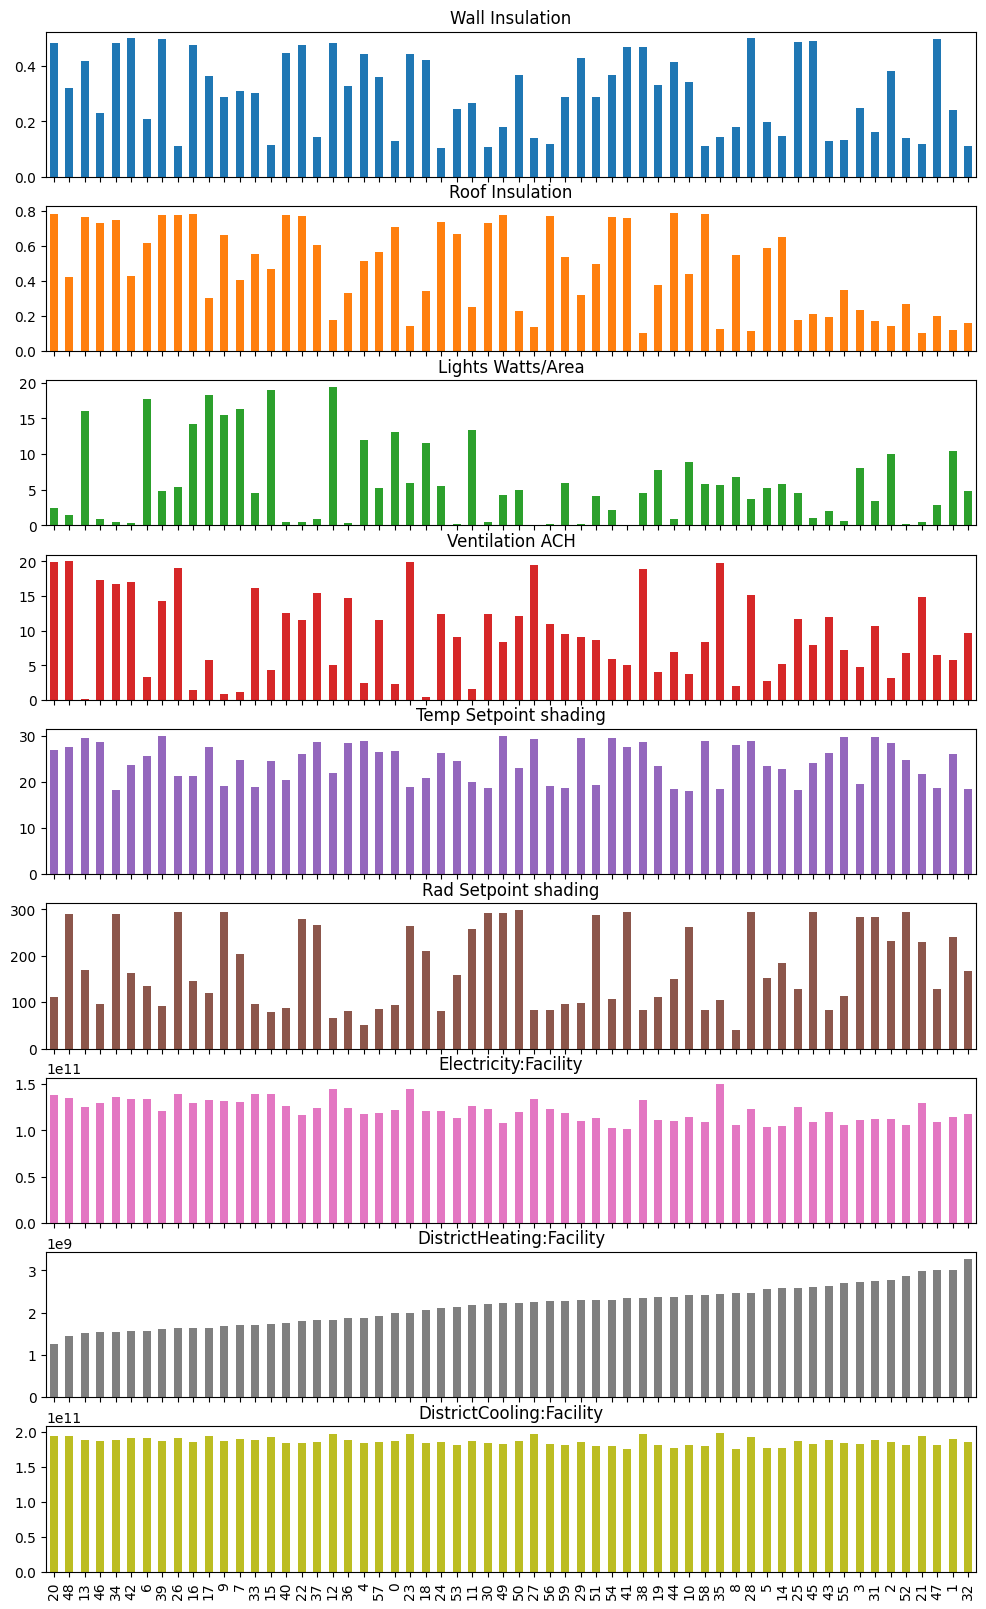

In [68]:
samples_original_df = samples_original_df.sort_values(by=output_cols[1])
ax=samples_original_df.plot.bar(subplots=True,legend=None, figsize=(12,20))

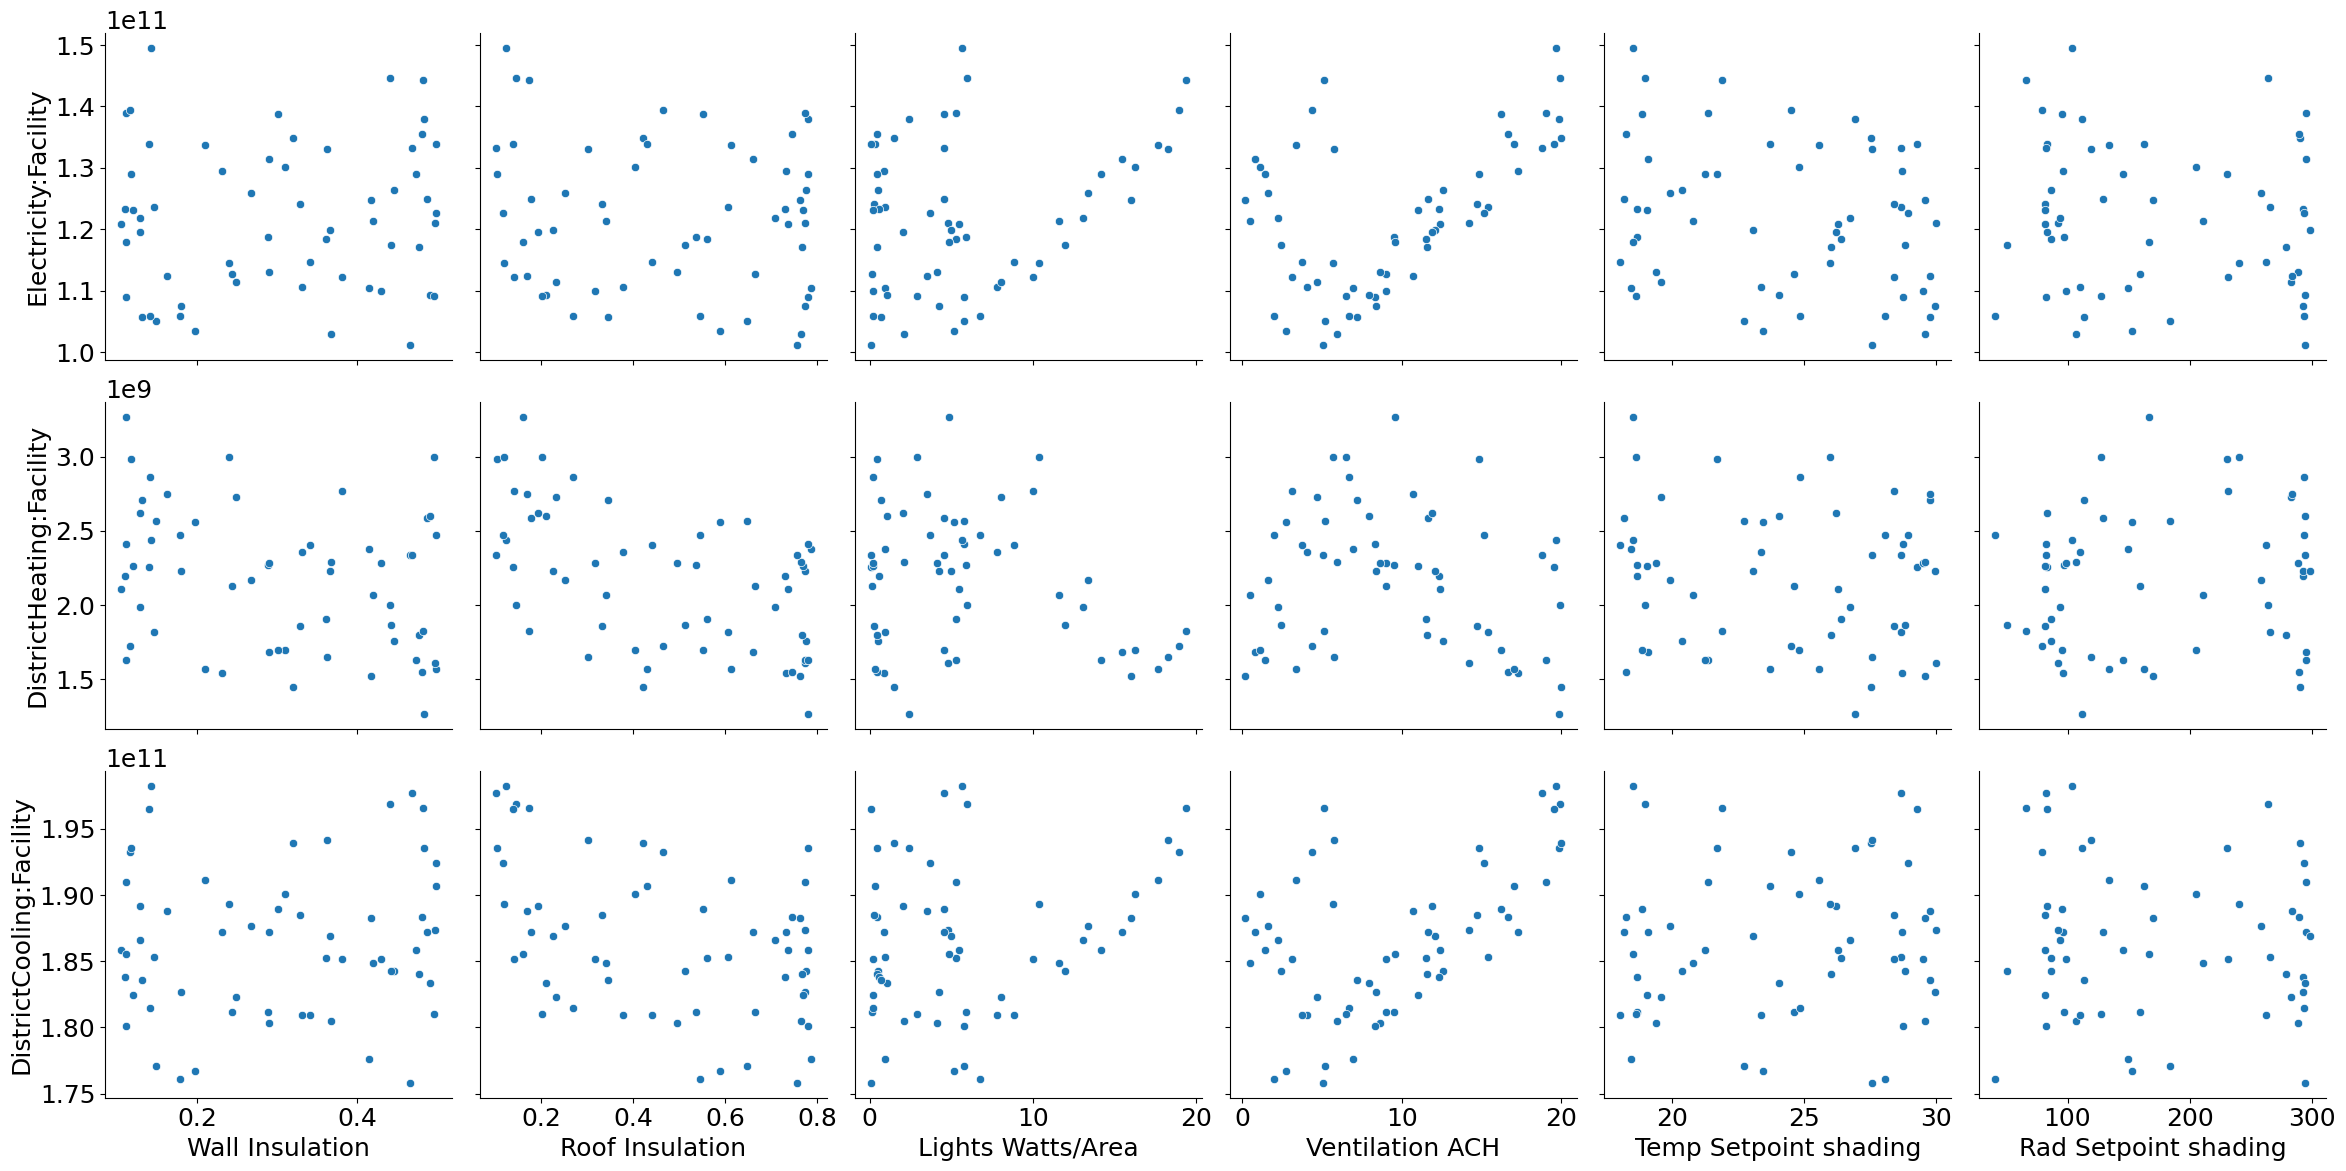

In [70]:
plt.rcParams.update({'font.size': 18})
_=pairplot(samples_original_df,x_vars=input_cols, y_vars=objectives, kind="scatter",height=4)

In [73]:
corr=samples_original_df.corr()
corr

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
Wall Insulation,1.000000,-0.036451,0.030285,0.009907,-0.029127,0.033145,0.087725,-0.298374,0.081009
Roof Insulation,-0.036451,1.000000,-0.070646,-0.092097,0.063092,-0.098232,-0.117635,-0.543189,-0.433581
Lights Watts/Area,0.030285,-0.070646,1.000000,-0.618698,-0.053431,-0.123907,0.297120,-0.260779,0.247817
Ventilation ACH,0.009907,-0.092097,-0.618698,1.000000,0.020251,0.012005,0.484247,-0.186950,0.512391
Temp Setpoint shading,-0.029127,0.063092,-0.053431,0.020251,1.000000,-0.196960,-0.243727,-0.126110,0.077180
Rad Setpoint shading,0.033145,-0.098232,-0.123907,0.012005,-0.196960,1.000000,-0.113708,0.130265,-0.069885
Electricity:Facility,0.087725,-0.117635,0.297120,0.484247,-0.243727,-0.113708,1.000000,-0.587911,0.861553
DistrictHeating:Facility,-0.298374,-0.543189,-0.260779,-0.186950,-0.126110,0.130265,-0.587911,1.000000,-0.342137
DistrictCooling:Facility,0.081009,-0.433581,0.247817,0.512391,0.077180,-0.069885,0.861553,-0.342137,1.000000


In [74]:
corr.drop(objectives, axis = 1, inplace = True)
corr.drop(['Roof Insulation','Wall Insulation', 'Lights Watts/Area','Ventilation ACH','Temp Setpoint shading', 'Rad Setpoint shading'], axis = 0 ,inplace = True)
corr

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading
Electricity:Facility,0.087725,-0.117635,0.297120,0.484247,-0.243727,-0.113708
DistrictHeating:Facility,-0.298374,-0.543189,-0.260779,-0.186950,-0.126110,0.130265
DistrictCooling:Facility,0.081009,-0.433581,0.247817,0.512391,0.077180,-0.069885


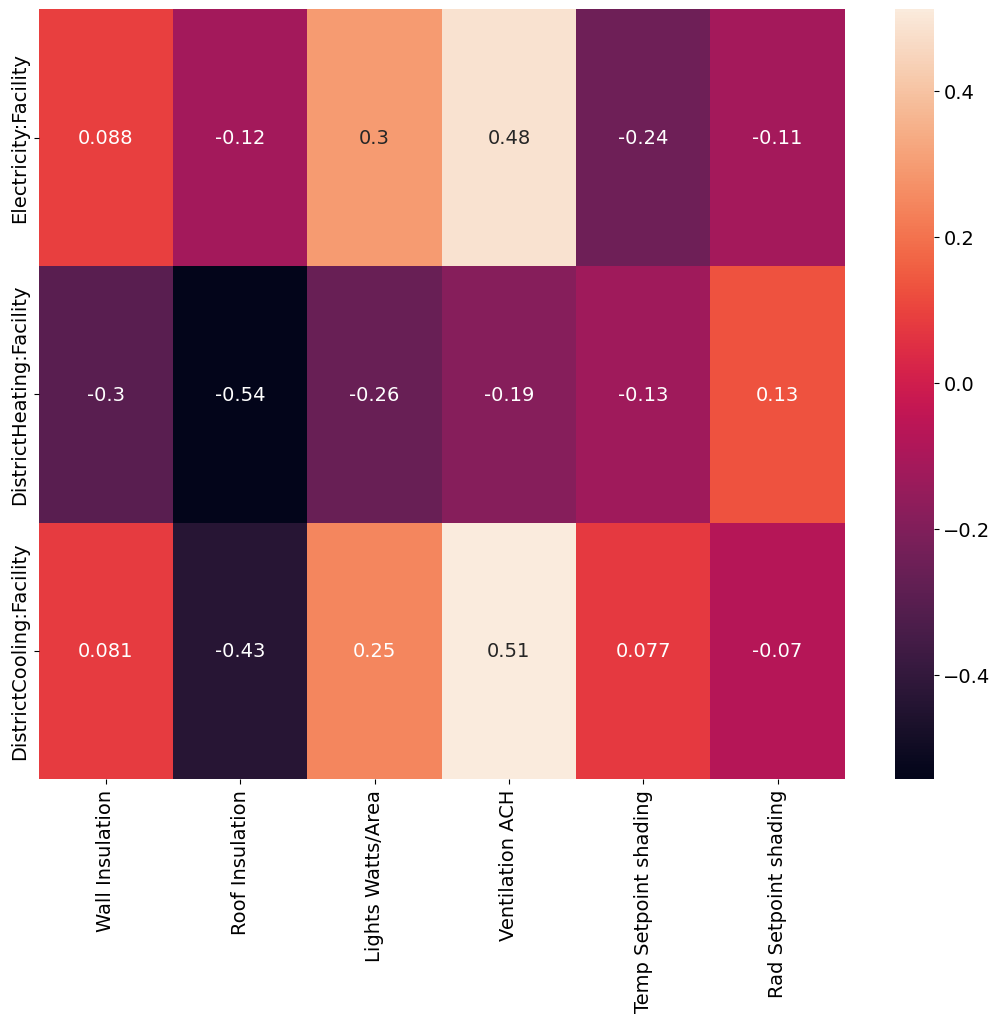

In [75]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize = (13,10))
_ = heatmap(corr,annot=True)

In [76]:
train_in, test_in, train_out, test_out = train_test_split(
    inputs_original_df, outputs_original_df, test_size=0.2
)

In [77]:
#second scaling we turn again the original samples in to scaled dataset to train and test surrogate models

scaler = StandardScaler()
train_in_scale = scaler.fit_transform(X=train_in)
test_in_scale = scaler.fit_transform(X=test_in)

scaler_out = StandardScaler()
train_out_scale = scaler_out.fit_transform(X=train_out)
test_out_scale = scaler_out.fit_transform(X=test_out)

In [78]:
hyperparameters = {
    "kernel": [
        None,
        1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
        1.0 * RationalQuadratic(length_scale=1.0, alpha=0.5),
        # ConstantKernel(0.1, (0.01, 10.0))*(DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0))**2),
        1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
    ]
}

folds = 3

gp = GaussianProcessRegressor(normalize_y=True)

clf = GridSearchCV(gp, hyperparameters, cv=folds)

clf.fit(train_in_scale, train_out_scale)

best_gp = clf.best_estimator_ 

prediction_gp = scaler_out.inverse_transform(best_gp.predict(test_in_scale))

In [79]:
hyperparameters = {
    "hidden_layer_sizes": (
        (len(parameters) * 16,),
        (len(parameters) * 16, len(parameters) * 16),
    ),
    "alpha": [1, 10, 10 ** 3],
}

neural_net = MLPRegressor(max_iter=1000, early_stopping=False)
folds = 3

clf = GridSearchCV(neural_net, hyperparameters, cv=folds)
clf.fit(train_in_scale, train_out_scale)

nn_model = clf.best_estimator_

prediction_nn = scaler_out.inverse_transform(nn_model.predict(test_in_scale))

In [80]:
def build_model():
    model = keras.Sequential(
        [
            layers.Input(shape=(train_in_scale.shape[1], )),
            layers.Dense(32, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(3),
        ]
    )

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", "mse"])
    return model

tf_model = build_model()

tf_model.summary()

EPOCHS = 1000

history = tf_model.fit(
    train_in_scale,
    train_out_scale,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=0,
)

prediction_tf = scaler_out.inverse_transform(tf_model.predict(test_in_scale))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,515 (17.64 KB)

 Trainable params: 4,515 (17.64 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [81]:
mse = mean_squared_error(prediction_gp,
                         test_out.values,
                         multioutput='raw_values')

# 2) RMSE
rmse = np.sqrt(mse)

mean_vals = test_out.mean().values
rmse_pct = rmse / mean_vals * 100


print("GP:")
print("RMSE:", rmse)
print("RMSE %:", rmse_pct)

GP:
RMSE: [1.30605670e+09 1.08990035e+08 1.71843282e+09]
RMSE %: [1.06962633 5.102352   0.91867403]


In [82]:
mse_nn = mean_squared_error(
    prediction_nn,
    test_out.values,
    multioutput='raw_values'
)

# 2) RMSE
rmse_nn = np.sqrt(mse_nn)

mean_vals = test_out.mean().values
rmse_pct_nn = rmse_nn / mean_vals * 100

print("NN:")
print("RMSE NN:", rmse_nn)
print("RMSE % NN:", rmse_pct_nn)

NN:
RMSE NN: [1.43901783e+09 1.15288491e+08 1.50758873e+09]
RMSE % NN: [1.17851802 5.3972133  0.8059568 ]


In [83]:
mse_tf = mean_squared_error(
    prediction_tf,
    test_out.values,
    multioutput='raw_values'
)

# 2) RMSE
rmse_tf = np.sqrt(mse_tf)

mean_vals = test_out.mean().values
rmse_pct_tf = rmse_tf / mean_vals * 100


print("TF:")
print("RMSE TensorFlow:", rmse_tf)
print("RMSE % TensorFlow:", rmse_pct_tf)

TF:
RMSE TensorFlow: [4.54896991e+09 1.90234870e+08 2.70203378e+09]
RMSE % TensorFlow: [3.72548756 8.90581671 1.44450702]


In [84]:
parameters = insulation_param + [lights_param]  + ventilationAchParam + setpointParams

objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility']

In [85]:
def evaluation_func(ind, scaler=scaler):
    ind = scaler.transform(X=[ind])
    return (scaler_out.inverse_transform(nn_model.predict(ind))[0]).tolist()

evaluator = EvaluatorGeneric(evaluation_func, problem)

srinputs = sampling.dist_sampler(sampling.lhs, problem, 500)
sroutputs = evaluator.df_apply(srinputs)
srresults = srinputs.join(sroutputs)
srresults.head()

Executing:   0%|          | 0/500 [00:00<?, ?row/s]

,Wall Insulation,Roof Insulation,Ventilation ACH,Lights Watts/Area,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
0,0.277376,0.309460,1.096478,8.915919,27.733470,81.743654,1.100699e+11,2.315674e+09,1.832624e+11
1,0.269148,0.596438,1.756326,6.896435,22.453877,132.107511,1.090399e+11,2.271869e+09,1.789706e+11
2,0.320183,0.305559,5.106061,17.425379,18.970693,192.538568,1.389785e+11,1.972721e+09,1.920038e+11
3,0.179506,0.417157,0.667467,8.984718,27.270223,152.525898,1.096838e+11,2.263214e+09,1.819922e+11
4,0.383324,0.501806,1.193422,5.509194,27.424437,150.103085,1.036492e+11,2.220618e+09,1.787861e+11


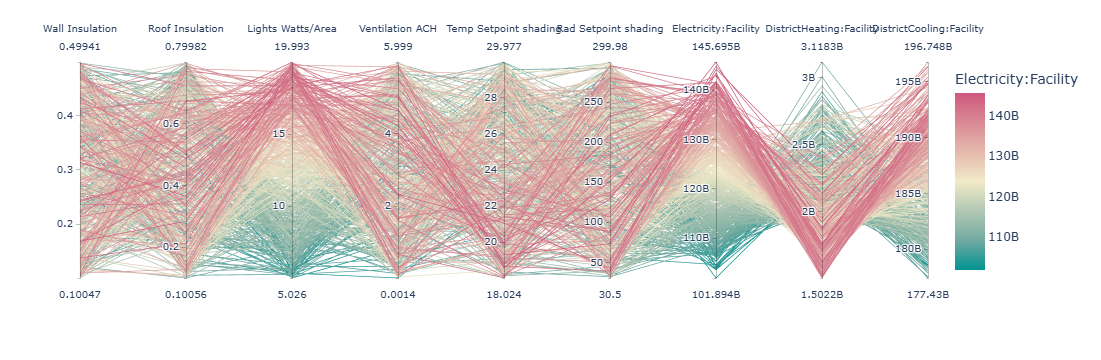

In [86]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

features = input_cols
import plotly.express as px
fig = px.parallel_coordinates(srresults,color="Electricity:Facility", dimensions=features+objectives,
                             color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

In [87]:
from platypus import Problem, Real, NSGAII
import numpy as np

# 1) Número de variables y de objetivos
d = len(features)
m = len(objectives)

# 2) Monta el problema Platypus “a mano”
plat_prob = Problem(d, m)
plat_prob.types[:] = [
    Real(param.value_descriptor.min, param.value_descriptor.max)
    for param in parameters
]
plat_prob.function = lambda xs: tuple(evaluation_func(xs))

# 3) Corre NSGA-II
algo = NSGAII(plat_prob, population_size=10000)
algo.run(5000)

# 4) Saca tu frente Pareto
pareto = algo.result
objectives_array = np.array([sol.objectives for sol in pareto])

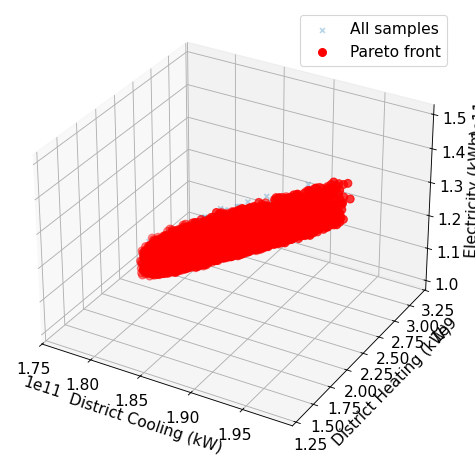

In [88]:
pareto_sols = algo.result
X_pareto = np.array([sol.variables  for sol in pareto_sols])
Y_pareto = np.array([sol.objectives for sol in pareto_sols])

# 2) Montar DataFrame de Pareto con las mismas columnas que srresults
opt_df = pd.DataFrame(
    np.hstack([X_pareto, Y_pareto]),
    columns=features + objectives
)

# 3) Graficar todo el muestreo inicial y el frente Pareto en 3D
fig = plt.figure(figsize=(8, 6), dpi=80)
ax  = fig.add_subplot(111, projection='3d')

# Muestreo inicial en azul con cruces
ax.scatter(
    srresults["DistrictCooling:Facility"],
    srresults["DistrictHeating:Facility"],
    srresults["Electricity:Facility"],
    marker='x', alpha=0.3, label='All samples'
)

# Frontera de Pareto en rojo con círculos
ax.scatter(
    opt_df["DistrictCooling:Facility"],
    opt_df["DistrictHeating:Facility"],
    opt_df["Electricity:Facility"],
    c='r', marker='o', s=50, label='Pareto front'
)

ax.set_xlabel("District Cooling (kW)")
ax.set_ylabel("District Heating (kW)")
ax.set_zlabel("Electricity (kWh)")
ax.legend()
plt.tight_layout()
plt.show()

In [89]:
opt_df

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
0,0.437308,0.231904,16.620769,2.371092,28.496895,151.445755,1.305493e+11,1.851682e+09,1.924656e+11
1,0.230888,0.652835,14.759092,5.743668,27.343989,250.155622,1.282698e+11,1.699614e+09,1.889832e+11
2,0.246866,0.430031,18.311320,2.258509,25.304919,105.470059,1.380840e+11,1.624675e+09,1.928640e+11
3,0.166105,0.673166,9.216713,5.583749,24.581015,190.084163,1.156555e+11,2.079420e+09,1.826749e+11
4,0.153430,0.756483,19.814267,2.994654,25.145135,206.935522,1.408420e+11,1.500807e+09,1.931552e+11
...,...,...,...,...,...,...,...,...,...
9995,0.318211,0.749234,7.521879,4.149215,22.550289,266.317382,1.125248e+11,2.077252e+09,1.805884e+11
9996,0.110691,0.481564,7.313289,1.290570,18.919129,46.328561,1.112826e+11,2.572257e+09,1.793635e+11
9997,0.255684,0.647076,7.493542,3.351820,28.115843,260.952534,1.076578e+11,2.151311e+09,1.806982e+11
9998,0.276381,0.327913,19.120648,2.517865,28.474586,161.479555,1.367304e+11,1.665431e+09,1.942760e+11


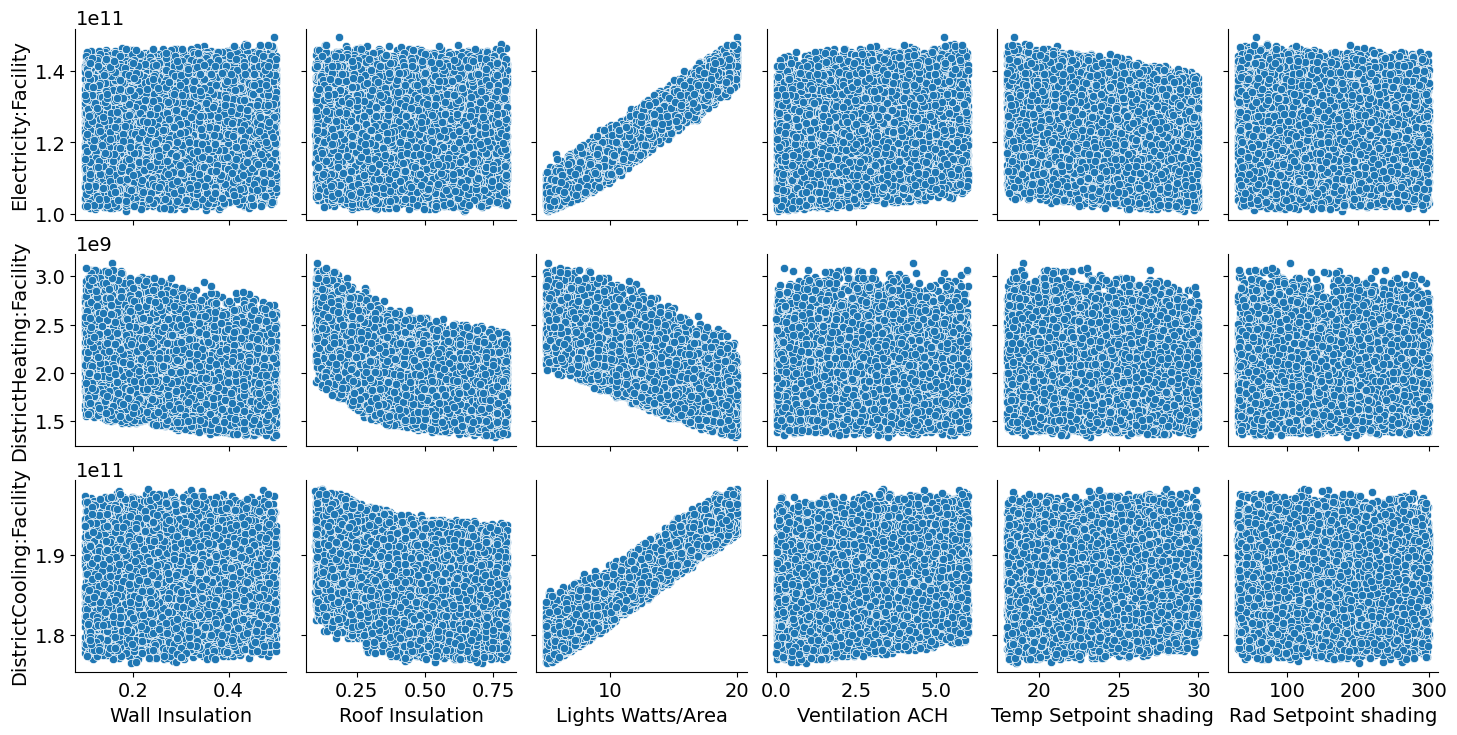

In [90]:
_=pairplot(opt_df,x_vars=input_cols, y_vars=objectives, kind="scatter")

In [91]:
pareto_sols = algo.result  # o NSGAII(...) según tu opción B
X_pareto = np.array([sol.variables  for sol in pareto_sols])
Y_pareto = np.array([sol.objectives for sol in pareto_sols])
opt_df = pd.DataFrame(np.hstack([X_pareto, Y_pareto]), columns=features + objectives)

In [92]:
corr=opt_df.corr()

corr.drop(objectives, axis = 1, inplace = True)
corr.drop(features, axis = 0 ,inplace = True)
corr

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading
Electricity:Facility,0.066074,0.062661,0.966404,0.112545,-0.204547,-0.052627
DistrictHeating:Facility,-0.317311,-0.571137,-0.713172,-0.062089,-0.062744,-0.019788
DistrictCooling:Facility,0.000584,-0.234801,0.949919,0.126296,0.051586,-0.005802


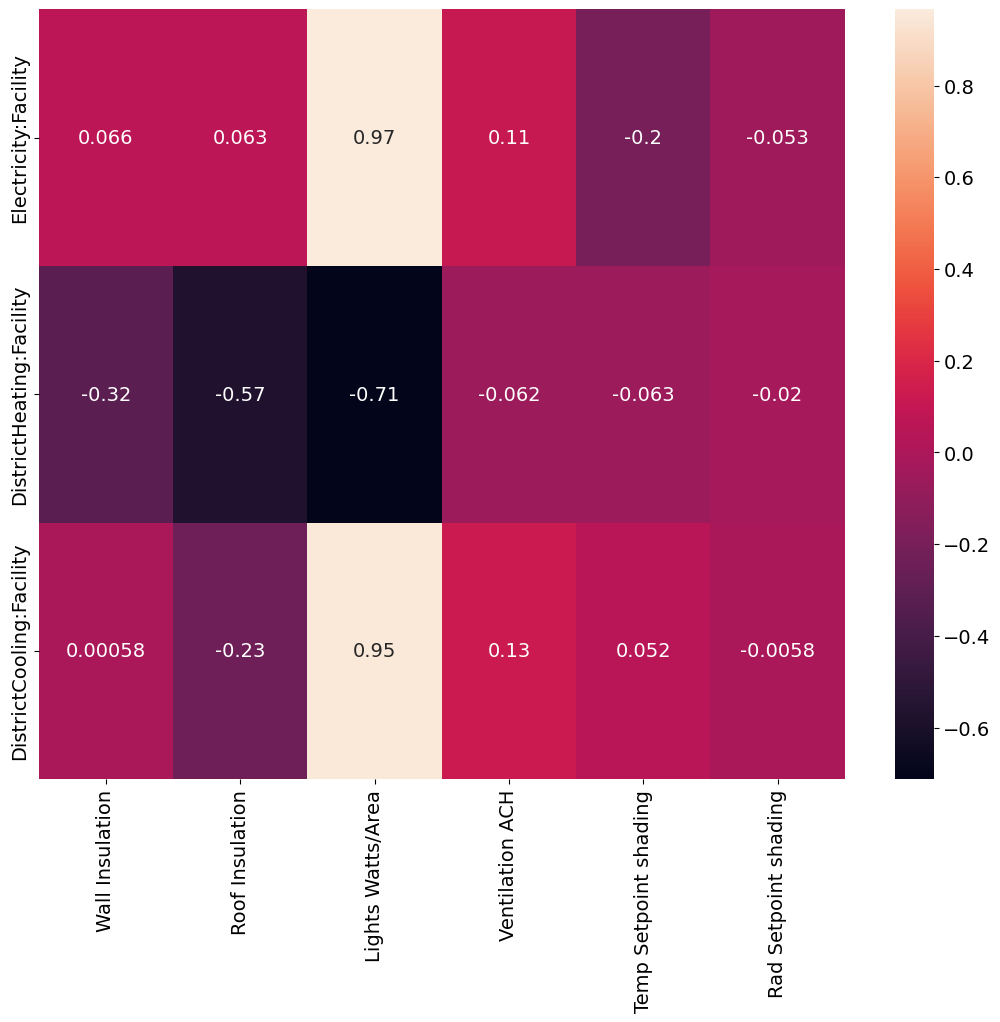

In [93]:
plt.figure(figsize = (13,10))
_ = heatmap(corr,annot=True)

In [94]:
opt_df['Total'] = opt_df['Electricity:Facility'] + opt_df['DistrictHeating:Facility'] + opt_df['DistrictCooling:Facility']
opt_df['Dist'] = opt_df.apply(lambda row : np.sqrt(pow(row["DistrictCooling:Facility"],2) + pow(row["DistrictHeating:Facility"],2) + pow(row["Electricity:Facility"],2)),axis=1)

opt_df[opt_df.Dist == opt_df.Dist.min()]

,Wall Insulation,Roof Insulation,Lights Watts/Area,Ventilation ACH,Temp Setpoint shading,Rad Setpoint shading,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,Total,Dist
46,0.109997,0.637029,5.085754,0.421164,25.616688,90.005286,1.016979e+11,2.498961e+09,1.773126e+11,2.815095e+11,2.044223e+11


In [95]:
optimal_params=opt_df.loc[opt_df.Dist == opt_df.Dist.min(),features].to_dict('records')[0]
optimal_params

{'Wall Insulation': 0.10999675196393328,
 'Roof Insulation': 0.6370285665950248,
 'Lights Watts/Area': 5.085753832555689,
 'Ventilation ACH': 0.42116352938067836,
 'Temp Setpoint shading': 25.616688445565096,
 'Rad Setpoint shading': 90.0052856206195}